In [1]:
import os
import sys
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader
import numpy as np
import einops
import wandb
import plotly.express as px
from pathlib import Path
import itertools
import random
from IPython.display import display
import wandb
from jaxtyping import Float, Int, Bool, Shaped, jaxtyped
from typing import Union, Optional, Tuple, Callable, Dict
import typeguard
from functools import partial
import copy
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
import pandas as pd
import torch
import matplotlib.pyplot as plt

import circuits.eval_sae_as_classifier as eval_sae
import circuits.analysis as analysis
import circuits.eval_board_reconstruction as eval_board_reconstruction
import circuits.get_eval_results as get_eval_results
import circuits.f1_analysis as f1_analysis
import circuits.utils as utils
import circuits.pipeline_config as pipeline_config
from circuits.dictionary_learning.dictionary import AutoEncoder, GatedAutoEncoder, AutoEncoderNew

# Make sure exercises are in the path
chapter = r"chapter1_transformer_interp"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "part53_othellogpt"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

extract_dir = '/root/ARENA_3.0/chapter1_transformer_interp/exercises/extracted_files'
sys.path.append(extract_dir)
sys.path.append("/root/miniconda3/envs/arena-env/lib/python3.11/site-packages")
from huggingface_hub import hf_hub_download
import chess_utils
#from plotly_utils import imshow
#from neel_plotly import scatter, line

MAIN = __name__ == "__main__"

device = t.device('cuda' if t.cuda.is_available() else 'cpu')
import pickle
with open('meta.pkl', 'rb') as picklefile:
    meta = pickle.load(picklefile)


/opt/conda/envs/chessgpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch
import sys
sys.path.insert(0, '/root/train_ChessGPT')
from model import GPTConfig, GPT

# Load the fine-tuned model from nanoGPT checkpoint
ckpt_path = '/root/train_ChessGPT/out-chess-8layer/ckpt.pt'
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k, v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(device)

print(f"Loaded fine-tuned model from {ckpt_path}")
print(f"Model config: {checkpoint['model_args']}")

# Path to the model file (adjust the file name as needed)
autoencoder_group_path = Path("/root/chessgpt_git/chessgpt_git/SAE_BoardGameEval/autoencoders/testing_chess/")
autoencoder_path = Path("/root/chessgpt_git/chessgpt_git/SAE_BoardGameEval/autoencoders/testing_chess/trainer4/ae.pt")

# Load the model weights (assuming the model definition is available)
autoencoder = torch.load(autoencoder_path)

In [3]:
train_dataset_name = f"chess_train_dataset_check_10k.pkl"

if os.path.exists(train_dataset_name):
    print("Loading statistics aggregation dataset")
    with open(train_dataset_name, "rb") as f:
        train_data = pickle.load(f)
else:
    train_data = eval_sae.construct_dataset(
        False,
        [chess_utils.board_to_check_state],
        10000,
        split="train",
        device=device,
        precompute_dataset=True,
    )
    with open(train_dataset_name, "wb") as f:
        pickle.dump(train_data, f)
sae = AutoEncoder.from_pretrained(Path(autoencoder_path), device=device)

Loading statistics aggregation dataset


In [4]:
games_close_to_check = []

for i, pgn in enumerate(train_data['decoded_inputs']):
    for j in range(len(pgn)):
        if pgn[j] == '+':
            games_close_to_check.append((i, j))

print(len(games_close_to_check))
print(games_close_to_check[0])
print(train_data['decoded_inputs'][games_close_to_check[0][0]][games_close_to_check[0][1]])

train_data['board_to_check_state'].nonzero()[:20]



12291
(3, 71)
+


tensor([[  3,  72,   0,   0,   0],
        [  3,  73,   0,   0,   0],
        [  3,  74,   0,   0,   0],
        [  3,  75,   0,   0,   0],
        [  4, 199,   0,   0,   0],
        [  4, 200,   0,   0,   0],
        [  4, 201,   0,   0,   0],
        [  4, 202,   0,   0,   0],
        [  4, 203,   0,   0,   0],
        [  4, 204,   0,   0,   0],
        [  4, 205,   0,   0,   0],
        [  4, 235,   0,   0,   0],
        [  4, 236,   0,   0,   0],
        [  4, 237,   0,   0,   0],
        [  4, 238,   0,   0,   0],
        [  4, 239,   0,   0,   0],
        [  4, 240,   0,   0,   0],
        [  4, 241,   0,   0,   0],
        [  7,  20,   0,   0,   0],
        [  7,  21,   0,   0,   0]], device='cuda:0')

In [6]:

model_activations = []
def get_activation(name):
    def hook(model, input, output):
        model_activations.append(output)
    return hook
activation_handle = model.transformer.h[5].register_forward_hook(get_activation(f"resid_stream_{5}"))
activation_handle.remove()

In [ ]:
t.set_grad_enabled(False)
from copy import copy
from collections import defaultdict
import common
import chess, io
illegal_moves=[]
move_results_with_plus=[]
move_results_without_plus=[]
def find_last_ocurrence(arr, value):
    for i in range(-1, -len(arr), -1):
        if arr[i]==value:
            return i
    raise Exception
#think we don't need this, we can just move forward from the last char of the original string until we hit a space
def find_next_space(string, start_index):
    for i in range(start_index, len(string)):
        if string[i] == ' ':
            return i
    return len(string)  # Return the length of the string if no space is found
def is_legal_move(board, move_string):
    """
    Check if a given move string is legal on the current chess board.
    
    Args:
    board (chess.Board): The current chess board state.
    move_string (str): The move in algebraic notation (e.g., "e4", "Nf3", "O-O").
    
    Returns:
    bool: True if the move is legal, False otherwise.
    """
    try:
                # Parse the move string
        move = board.parse_san(move_string)
        
        # Check if the move is legal
        if move in board.legal_moves:
            return "legal"
        else:
            return "not in legal moves"
    except (chess.IllegalMoveError, chess.AmbiguousMoveError) as e:
        illegal_moves.append(move_string)
        if isinstance(e, chess.IllegalMoveError):
            return "illegal"
        else:
            return "ambiguous"


# Example usage:
# board = chess.Board()
# move = "e4"
# if is_legal_move(board, move):
#     print(f"{move} is a legal move")
# else:
#     print(f"{move} is not a legal move")


# Example usage:
# last_move = get_last_legal_move(pgn_string)
# if last_move:
#     print(f"The last legal move is: {last_move}")
# else:
#     print("No legal moves found or invalid PGN")

#feature_numbers=[167, 228, 410, 614, 706]
agg_results=common.get_aggregation_results(1000)
formatted_results=common.get_formatted_results(agg_results)
feature_numbers=common.get_true_feature_indices(formatted_results, 'board_to_check_state').tolist()
#print(feature_numbers)
num_samples = 10000

pgn_index_list = t.randint(10, 1000, (num_samples,))
move_index_list = t.randint(10, 256, (num_samples,))
legal_moves_without_plus=0
legal_moves_with_plus=0
same_moves_predicted=0
# for pgn_idx, move_idx in zip(pgn_index_list, move_index_list):
#     encoded_input = train_data['encoded_inputs'][pgn_idx][:move_idx]
#     activation_handle=model.transformer.h[5].register_forward_hook(get_activation(f"resid_stream_{5}"))
#     model(t.tensor(encoded_input).to(device)).logits[-1]
#     activation_handle.remove()
#     chess_gpt_activations = model_activations[0][0][0][-1]
#     model_activations = []
#     sae_activations = sae.encode(chess_gpt_activations)
#     this_feature_activation = sae_activations[feature_number].cpu().numpy() 
#     max_activation = max(max_activation, this_feature_activation)
#     if train_data['board_to_check_state'][pgn_idx, move_idx, 0, 0, 0] == 0:
#         not_check_activations.append(this_feature_activation)
#     else:
#         yes_check_activations.append(this_feature_activation)
num_sampled=0
num_available=train_data['board_to_check_state'].nonzero().shape[0]
current_sample=0
while num_sampled<num_samples and current_sample<num_available:
    pgn_idx, move_idx, _, _, _ = train_data['board_to_check_state'].nonzero()[current_sample]
    current_sample+=1
    if move_idx==0 or not 4==train_data['encoded_inputs'][pgn_idx][move_idx-1]:
        continue
    num_sampled+=1
    encoded_input = train_data['encoded_inputs'][pgn_idx][:move_idx]
    current_board_string="".join([meta["itos"][c] for c in encoded_input])
    current_board=chess_utils.pgn_string_to_board(current_board_string)
    current_board_last_index=len(current_board_string)-1
    encoded_input_without_plus = copy(train_data['encoded_inputs'][pgn_idx][:move_idx])
    del encoded_input_without_plus[find_last_ocurrence(encoded_input_without_plus, 2)]
    assert len(encoded_input)-1==len(encoded_input_without_plus)

    token_move_with_plus=model.generate(t.tensor(encoded_input).to(device).to(torch.int64).unsqueeze(dim=0), max_new_tokens=7)
    token_move_without_plus=model.generate(t.tensor(encoded_input_without_plus).to(device).to(torch.int64).unsqueeze(dim=0), max_new_tokens=7)
    string_move_with_plus="".join([meta["itos"][c] for c in token_move_with_plus.squeeze().tolist()])
    string_move_without_plus="".join([meta["itos"][c] for c in token_move_without_plus.squeeze().tolist()])
    with_plus_index=find_next_space(string_move_with_plus, current_board_last_index)
    without_plus_index=find_next_space(string_move_without_plus, current_board_last_index-1)
    move_with_plus=string_move_with_plus[current_board_last_index+1:with_plus_index]
    move_without_plus=string_move_without_plus[current_board_last_index:without_plus_index]
    if move_with_plus==move_without_plus:
        same_moves_predicted+=1
    # if is_legal_move(current_board, move_with_plus):
    #     legal_moves_with_plus+=1
    # if is_legal_move(current_board, move_without_plus):
    #     legal_moves_without_plus+=1
    move_results_with_plus.append(is_legal_move(current_board, move_with_plus))
    move_results_without_plus.append(is_legal_move(current_board, move_without_plus))




print(num_sampled, same_moves_predicted)

    








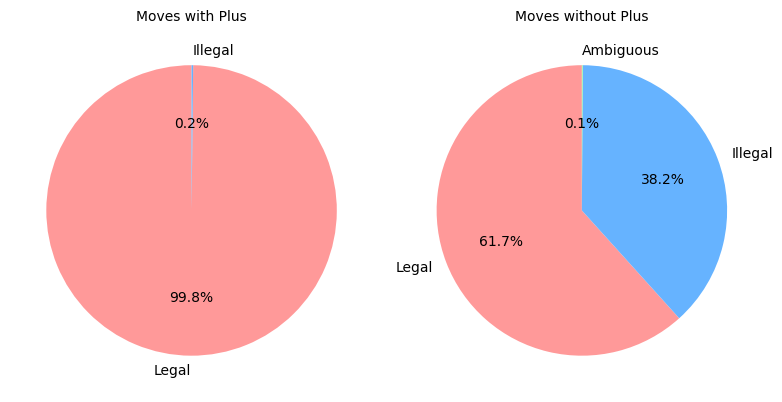

In [35]:
import matplotlib.pyplot as plt

# Count the occurrences of "legal", "illegal", and "ambiguous" moves
with_plus_legal = move_results_with_plus.count("legal")
with_plus_illegal = move_results_with_plus.count("illegal")
with_plus_ambiguous = move_results_with_plus.count("ambiguous")

without_plus_legal = move_results_without_plus.count("legal")
without_plus_illegal = move_results_without_plus.count("illegal")
without_plus_ambiguous = move_results_without_plus.count("ambiguous")

# Create pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for moves with plus
sizes_with_plus = [with_plus_legal, with_plus_illegal, with_plus_ambiguous]
labels_with_plus = ['Legal', 'Illegal', 'Ambiguous']
colors_with_plus = ['#ff9999', '#66b3ff', '#99ff99']

ax1.pie(sizes_with_plus, labels=labels_with_plus, colors=colors_with_plus, autopct='%1.1f%%', startangle=90)
ax1.set_title('Moves with Plus')

# Add a legend for the "with plus" chart
ax1.legend(labels_with_plus, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Pie chart for moves without plus
ax2.pie([without_plus_legal, without_plus_illegal, without_plus_ambiguous], 
        labels=['Legal', 'Illegal', 'Ambiguous'], 
        autopct='%1.1f%%')
ax2.set_title('Moves without Plus')

plt.tight_layout()
plt.show()
#print(move_with_plus, move_without_plus)

In [ ]:
t.set_grad_enabled(False)
from copy import copy
from collections import defaultdict
import common

#feature_numbers=[167, 228, 410, 614, 706]
agg_results=common.get_aggregation_results(1000)
formatted_results=common.get_formatted_results(agg_results)
feature_numbers=common.get_true_feature_indices(formatted_results, 'board_to_check_state').tolist()
print(feature_numbers)
num_samples = 10000

pgn_index_list = t.randint(10, 1000, (num_samples,))
move_index_list = t.randint(10, 256, (num_samples,))
yes_plus_feature_activations = defaultdict(list)
no_plus_feature_activations = defaultdict(list)
max_activations = defaultdict(int)

num_sampled=0
num_available=train_data['board_to_check_state'].nonzero().shape[0]
current_sample=0
while num_sampled<num_samples and current_sample<num_available:
    pgn_idx, move_idx, _, _, _ = train_data['board_to_check_state'].nonzero()[current_sample]
    current_sample+=1
    if move_idx==0 or not 4==train_data['encoded_inputs'][pgn_idx][move_idx-1]:
        continue
    num_sampled+=1
    encoded_input = train_data['encoded_inputs'][pgn_idx][:move_idx]
    encoded_input_without_plus = copy(train_data['encoded_inputs'][pgn_idx][:move_idx])
    del encoded_input_without_plus[find_last_ocurrence(encoded_input_without_plus, 2)]
    assert len(encoded_input)-1==len(encoded_input_without_plus)
    activation_handle=model.transformer.h[5].register_forward_hook(get_activation(f"resid_stream_{5}"))

    # nanoGPT returns (logits, loss) tuple, just run forward pass
    _ = model(t.tensor(encoded_input).to(device).unsqueeze(0))
    chess_gpt_activations = model_activations[0][0][-1]
    model_activations = []
    sae_activations = sae.encode(chess_gpt_activations)
    for feature_number in feature_numbers:
        this_feature_activation = sae_activations[feature_number].cpu().numpy() 
        max_activations[feature_number] = max(max_activations[feature_number], this_feature_activation)
        yes_plus_feature_activations[feature_number].append(this_feature_activation.item())
    

    # nanoGPT returns (logits, loss) tuple, just run forward pass
    _ = model(t.tensor(encoded_input_without_plus).to(device).unsqueeze(0))
    chess_gpt_activations = model_activations[0][0][-1]
    model_activations = []
    sae_activations = sae.encode(chess_gpt_activations)
    for feature_number in feature_numbers:
        this_feature_activation = sae_activations[feature_number].cpu().numpy() 
        max_activations[feature_number] = max(max_activations[feature_number], this_feature_activation)
        no_plus_feature_activations[feature_number].append(this_feature_activation.item())



    activation_handle.remove()

    

multiplier = 0.2

# Calculate mean values for each feature
mean_yes_plus = [np.mean(yes_plus_feature_activations[feature]) for feature in feature_numbers]
mean_no_plus = [np.mean(no_plus_feature_activations[feature]) for feature in feature_numbers]

# Set up the bar chart
x = np.arange(len(feature_numbers))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, mean_yes_plus, width, label='With Plus')
rects2 = ax.bar(x + width/2, mean_no_plus, width, label='Without Plus')

# Add labels and title
ax.set_ylabel('Mean Activation')
ax.set_xlabel('Feature Number')
ax.set_title('Mean Activation for Each Feature With and Without Plus')
ax.set_xticks(x)
ax.set_xticklabels(feature_numbers)
ax.legend()

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right')

# Adjust layout and display the plot
fig.tight_layout()
plt.show()